In [45]:
import numpy as np
from numpy import random as rnd

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from utils import*
from potential_func import PotentialFunctionClassifier
from random_forest import RandomForestClassifier

import pickle
import dill

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def serialize(object, filename):
    with open("./tmp/" + filename + ".pickle", "wb") as file:
        dill.dump(object, file, protocol=dill.HIGHEST_PROTOCOL, fix_imports=True)


def deserialize(filename):
    with open("./tmp/" + filename + ".pickle", "rb") as file:
        return dill.load(file)
#dill.load_session("session.plk")

In [3]:
def show_test_results(y_pred):
    print("Accuracy on test: ", accuracy_score(y_pred, y_test))
    xs, ys = get_wrong_pred(y_pred, y_test, x_test)
    show_data(xs, ys, dpi=60)

In [7]:
x, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [ ]:
serialize(x, "x")
serialize(y, "y")

In [12]:
#split data according MNIST specification
x = deserialize("x")
y = deserialize("y")

x_train, x_test = np.split(x, [60000])
y_train, y_test = np.split(y.astype(int), [60000])

# 1. Logistic Regression

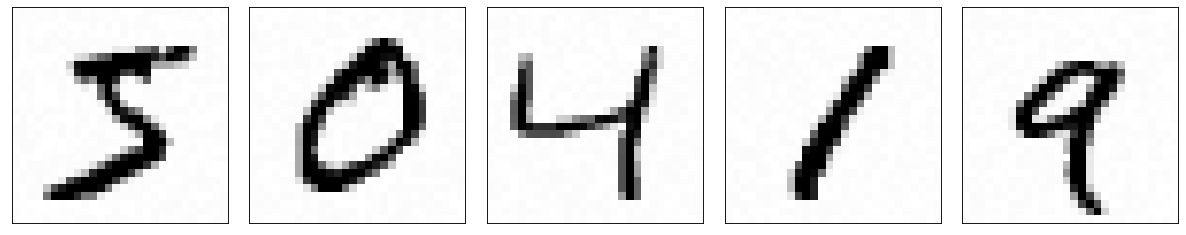

In [4]:
gen = rnd.RandomState(0)
x_train_noisy = np.clip(x_train + gen.random_sample(x_train.shape) * 5, 0, 255)
show_data(x_train_noisy)

In [5]:
coeffs = [1e-1, 1e-2, 1e-3]
logreg_classifiers = []
accuracies = []

for c in coeffs:
    logreg_classifiers.append(LogisticRegression(penalty="l1", max_iter=100, C=c, n_jobs=2, solver="saga"))
    logreg_classifiers[-1].fit(x_train_noisy, y_train)
    y_pred_ = logreg_classifiers[-1].predict(x_test)
    accuracies.append(accuracy_score(y_test, y_pred_))
    print(f"Accuracy of Logreg classifer with C={c}: {accuracies[-1]}")

C:\Users\goglo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy of Logreg classifer with C=0.1: 0.9031


C:\Users\goglo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy of Logreg classifer with C=0.01: 0.912


C:\Users\goglo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy of Logreg classifer with C=0.001: 0.9234


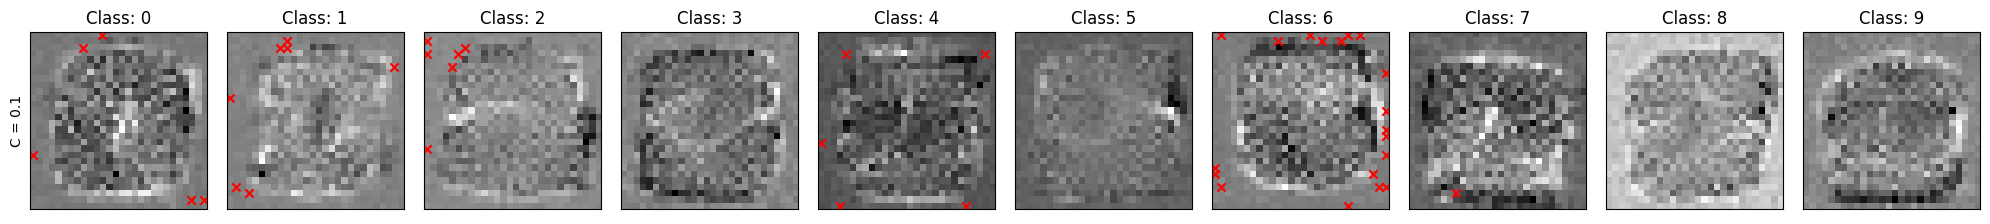

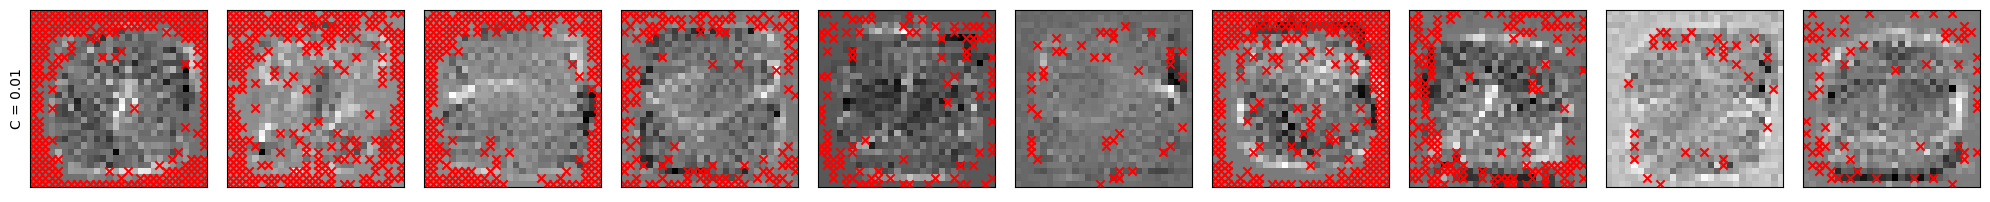

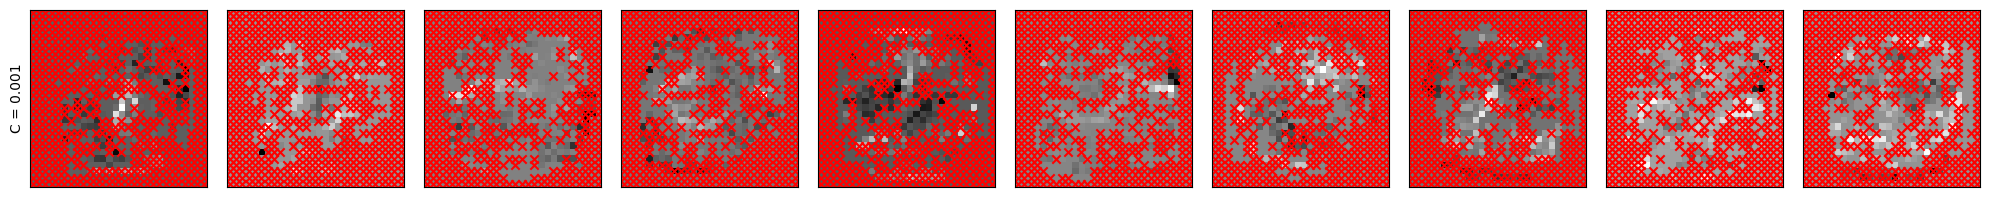

In [6]:
for j, classifier in enumerate(logreg_classifiers):
    coefs = classifier.coef_
    size = int(np.sqrt(coefs.shape[1]))
    images = coefs.reshape((coefs.shape[0], size, size))

    plt.figure(figsize=(20, 3), dpi=100)
    for i, img in enumerate(images):
        plt.subplot(1, images.shape[0], 1 + i)
        
        if j == 0:
            plt.title(f"Class: {i}")
        if i == 0:
            plt.ylabel(f"C = {coeffs[j]}")

        plt.imshow(img, cmap=cm.gray_r)
        indices = np.nonzero(img == 0)
        if len(indices) > 0:
            plt.scatter(*indices, c='r', marker='x')
        plt.yticks([])
        plt.xticks([])
    plt.tight_layout()
    

log(1 + exp(-((x_i, w) - w_0))) * y_i) + C * ||w||^2



1) Шум от (1, 5) к кажому пикселю, сравнить коэфф при L1 регуляризации 
2) (визуализация feature selection) 
3) Градиентный спуск и масштаб входных данных

# 2. KNN

In [2]:
parameters = {"n_neighbors": (5, 2, 8)}
knn = GridSearchCV(KNeighborsClassifier(), parameters, n_jobs=4, cv=3, verbose=2)
knn.fit(x_train, y_train)

y_pred2 = knn.predict(x_test)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


Accuracy on test:  0.9688
{'n_neighbors': 5}


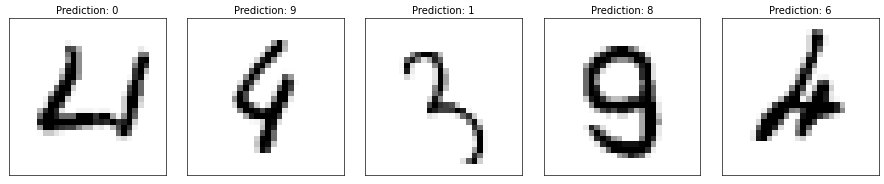

In [4]:
show_test_results(y_pred2)
print(knn.best_params_)

# Побробовать метод пот. фу-ий и вывести объекты с не нул потенциалами

In [32]:
n_train_samples = x_train.shape[0]
new_n = int(n_train_samples * 0.5)
x_train_s = x_train[:new_n, ...]
y_train_s = y_train[:new_n, ...]

pot_cls = PotentialFunctionClassifier(2)
pot_cls.fit(x_train_s, y_train_s)
pot_cls.reduce()

In [35]:
serialize(pot_cls, "pot_cls")

In [36]:
n_test_samples = x_test.shape[0]
new_n = n_test_samples // 100
x_test_s = x_test[:new_n, ...]
y_test_s = y_test[:new_n, ...]

y_pred_pot = pot_cls.predict(x_test_s)

Accuracy on test:  0.92


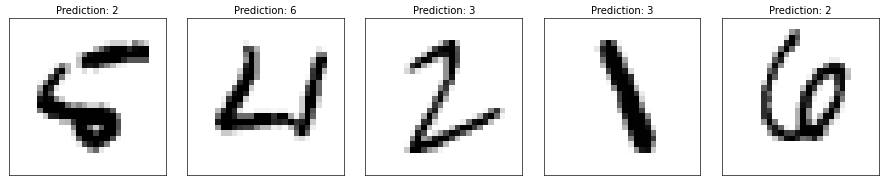

In [37]:
print("Accuracy on test: ", accuracy_score(y_pred_pot, y_test_s))
xs, ys = get_wrong_pred(y_pred_pot, y_test_s, x_test_s)
show_data(xs, ys, dpi=60)

# Сэмплы с ненулевым потенциалом

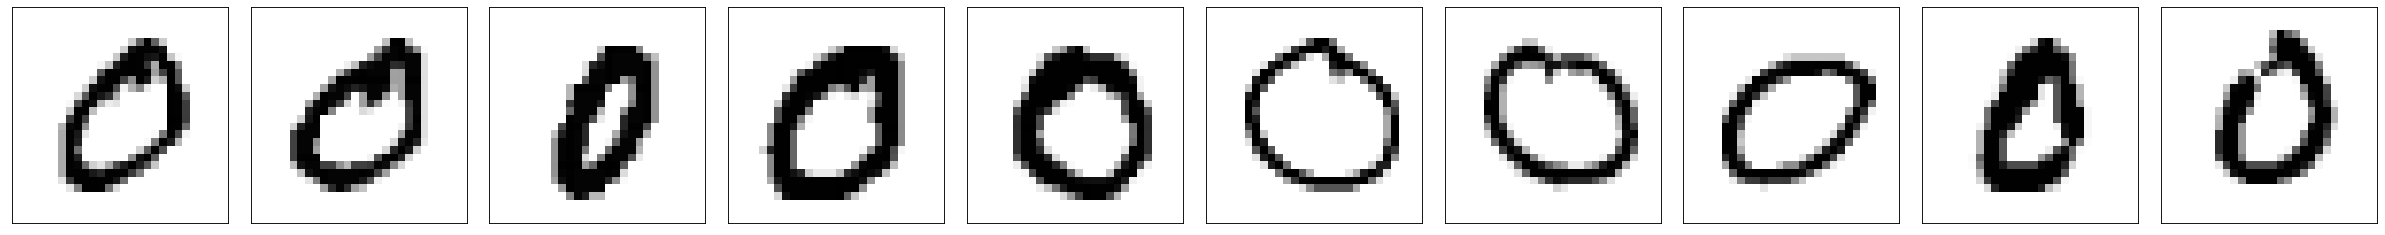

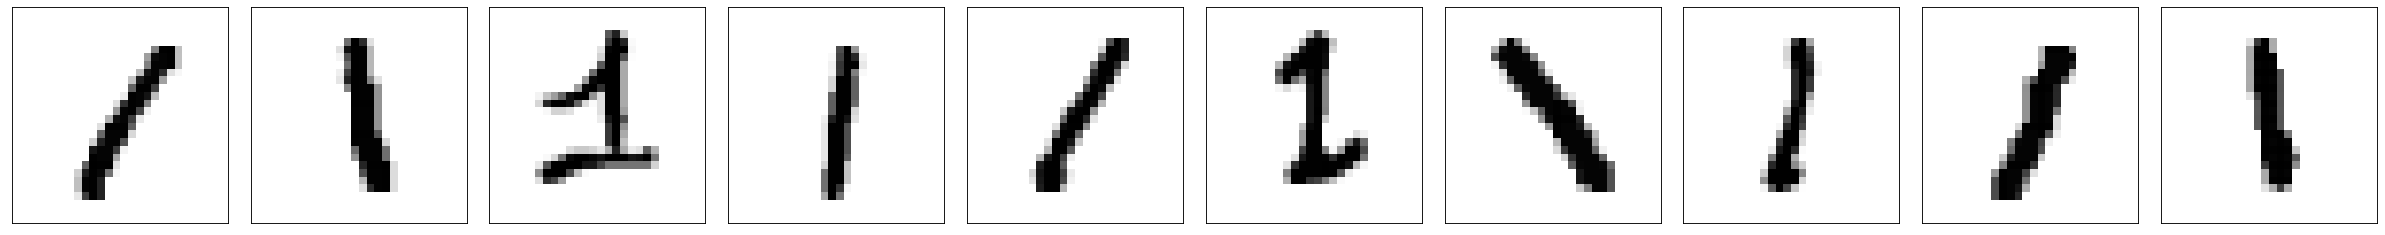

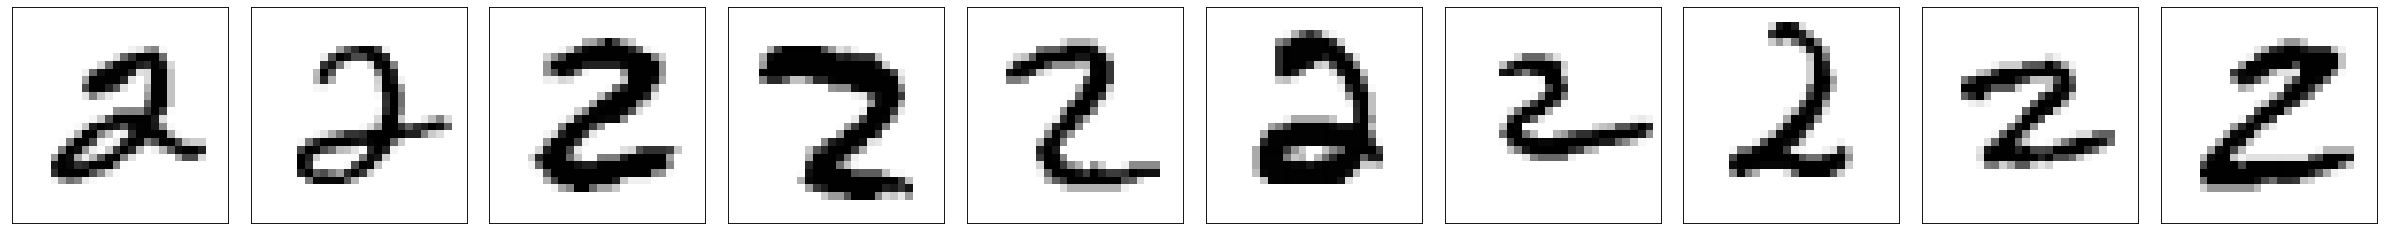

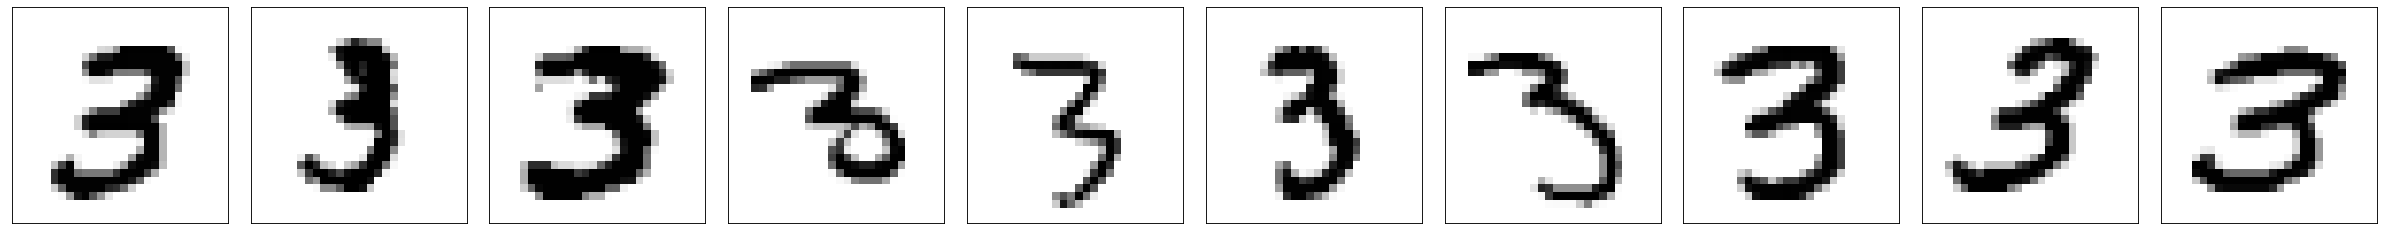

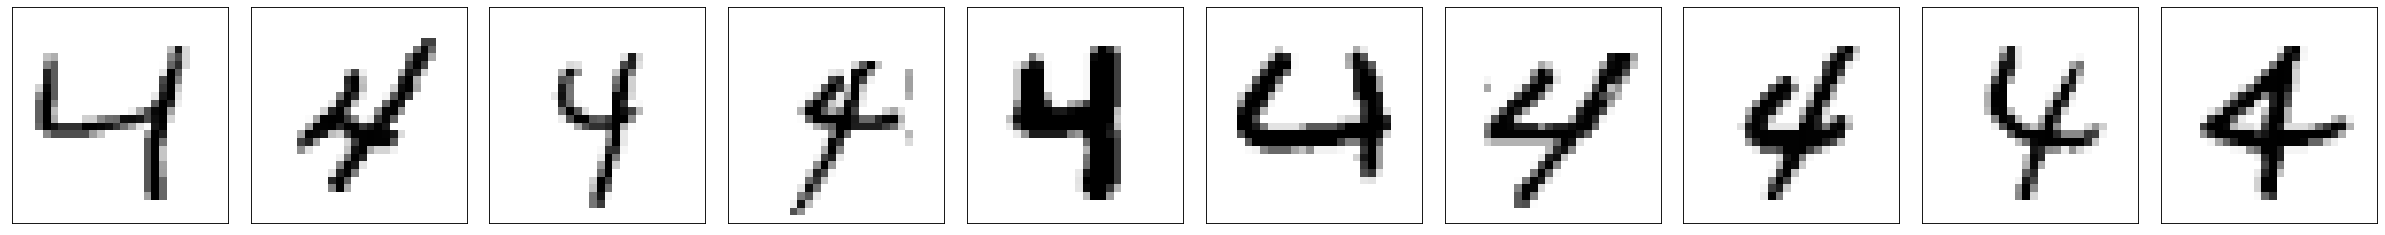

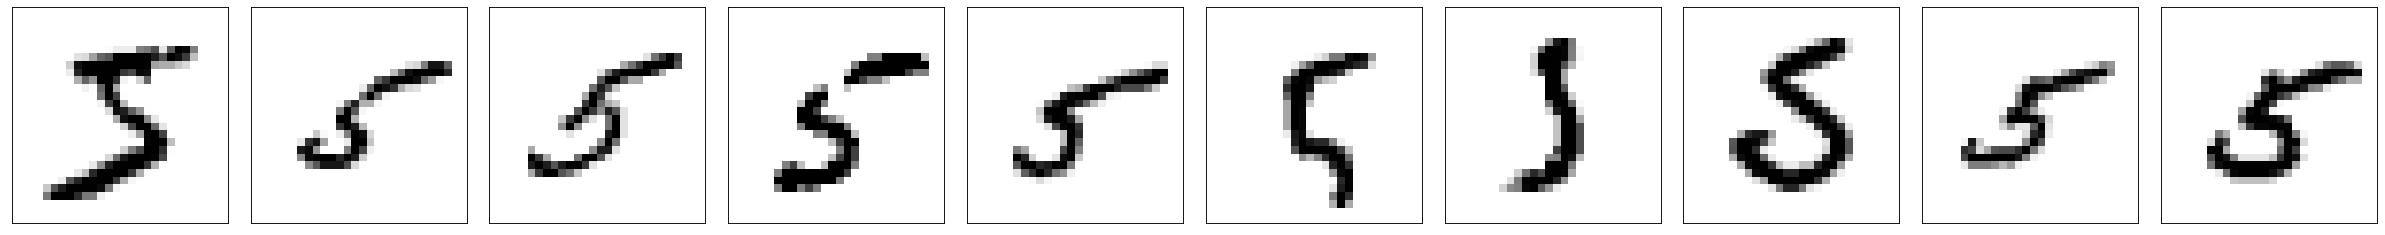

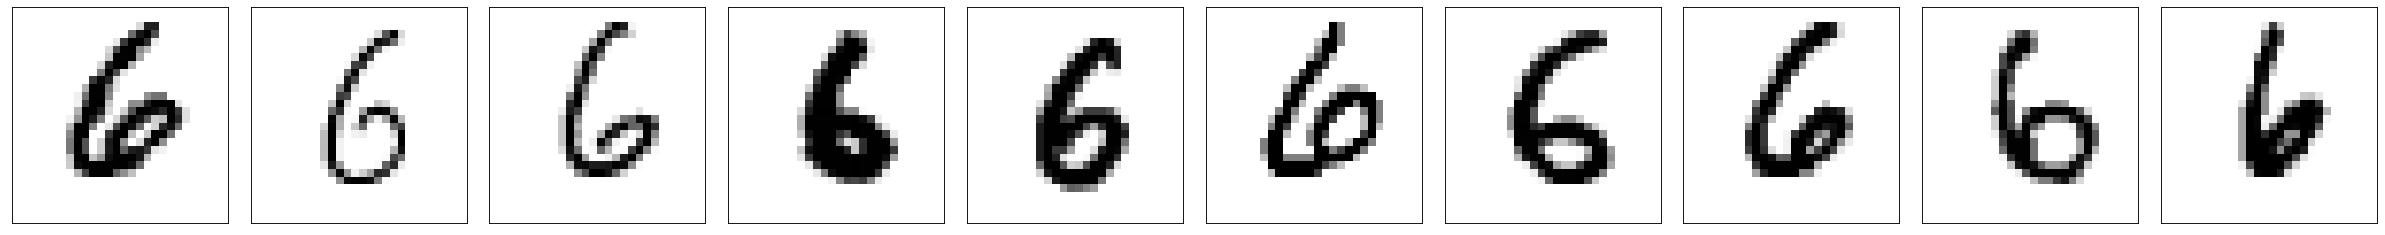

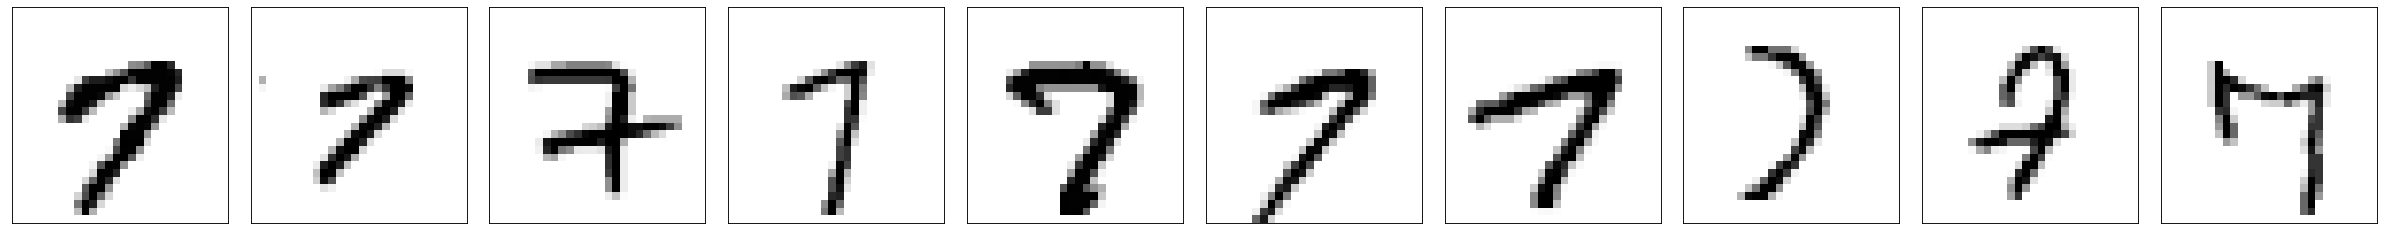

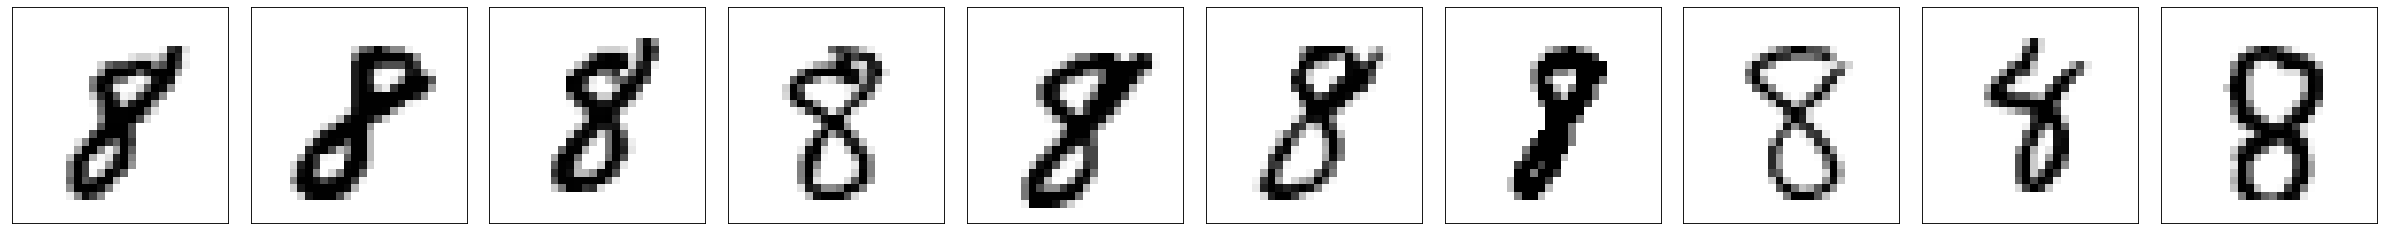

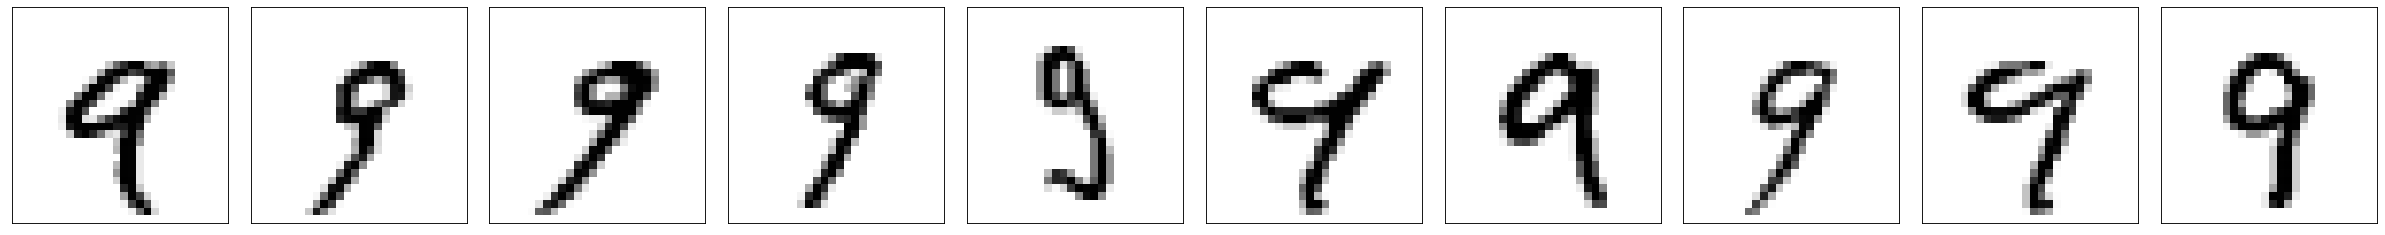

In [43]:
x_nonzero = x_train_s[pot_cls.indexes, ...]
y_nonzero = y_train_s[pot_cls.indexes]

for i in range(0, 10):
    show_data(x_nonzero[y_nonzero == i], number=10)

# 3. SVM

In [50]:
parameters = { "C": (0.1, 1, 10)}
svmlin_search = GridSearchCV(LinearSVC(max_iter=500), parameters, n_jobs=4, cv=3)
svmlin = make_pipeline(StandardScaler(), svmlin_search)
svmlin.fit(x_train, y_train)
y_pred4 = svmlin.predict(x_test)

C:\Users\goglo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy on test:  0.9131
{'C': 0.1}


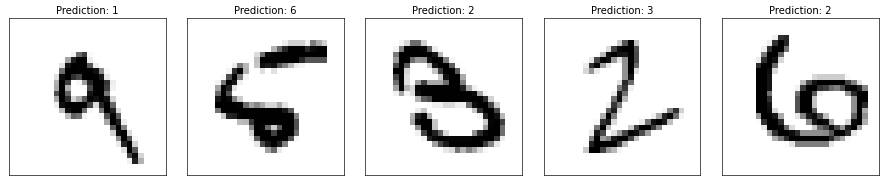

In [51]:
show_test_results(y_pred4)
print(svmlin_search.best_params_)

In [54]:
svm = SVC(max_iter=500, degree=9)
parameters = { "C": (1, 10), "kernel": ("poly", "rbf")}

svm_search = GridSearchCV(estimator=svm, param_grid=parameters, n_jobs=4,verbose=2)
svm_search.fit(x_train, y_train)
y_pred5 = svm_search.predict(x_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\goglo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy on test:  0.9843
{'C': 10, 'kernel': 'rbf'}


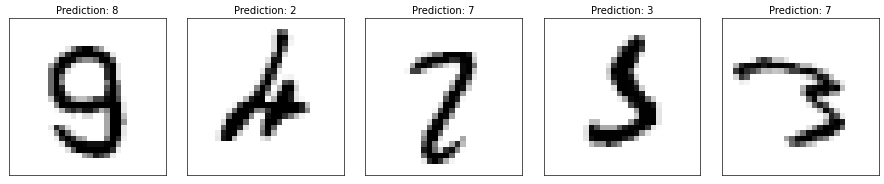

In [23]:
show_test_results(y_pred5)
print(svm_search.best_params_)

Number of support vectors: 9670


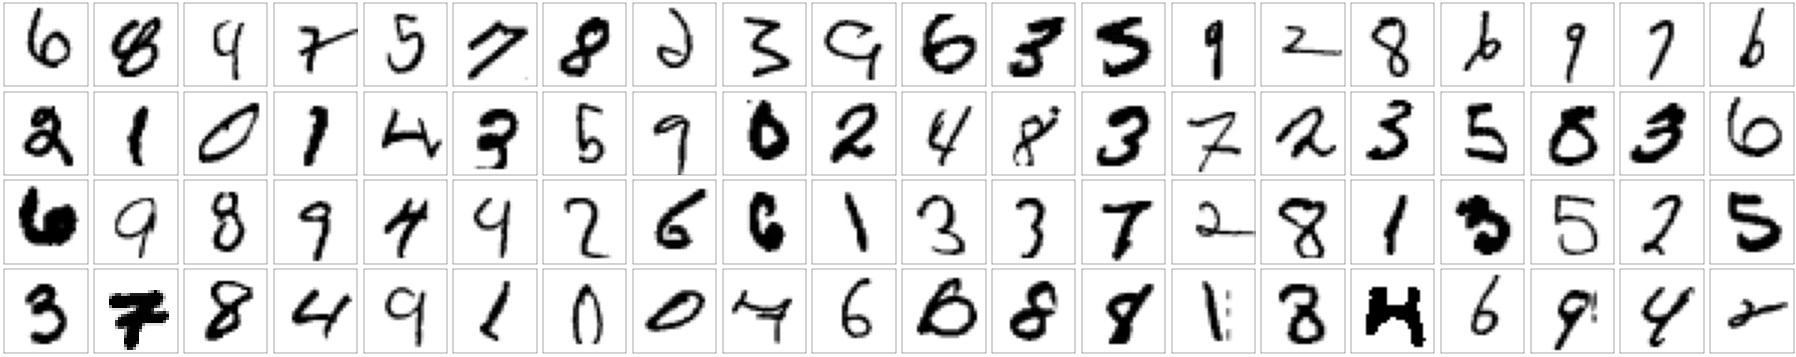

In [11]:
print("Number of support vectors:", svm_search.best_estimator_.support_vectors_.shape[0])

support_vectors = svm_search.best_estimator_.support_vectors_.copy()
gen = rnd.RandomState(0)
gen.shuffle(support_vectors)
show_data(support_vectors, dpi=30, number=80, shape=(4, 20))

# 4. Decision Tree

In [27]:
parameters = {'criterion':('gini', 'entropy'), 'splitter':('best', 'random'), "max_depth": (None, 30, 50)}
dtree_search = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs=4, cv=3, verbose=2)
dtree_search.fit(x_train, y_train)

y_pred6 = dtree_search.predict(x_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


Accuracy on test:  0.8877
{'criterion': 'entropy', 'max_depth': None, 'splitter': 'best'}


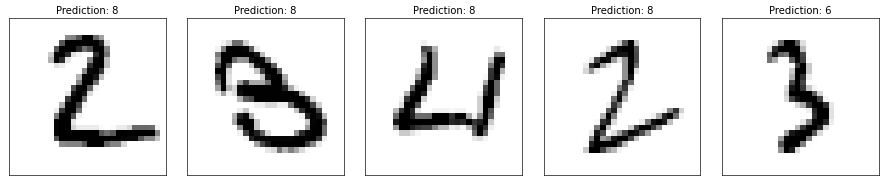

In [3]:
show_test_results(y_pred6)
print(dtree_search.best_params_)

q(1-q)

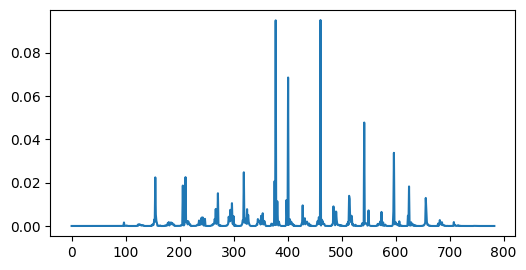

In [4]:
feauture_imp = dtree_search.best_estimator_.feature_importances_

plt.figure(figsize=(6, 3), dpi=100)
plt.plot(feauture_imp);

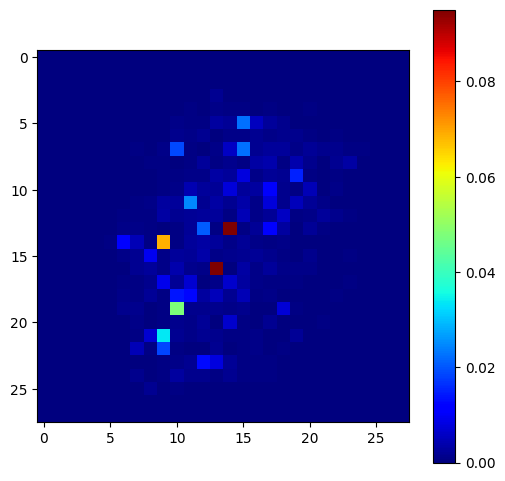

In [17]:
plt.figure(figsize=(6, 6), dpi=100)
plt.imshow(feauture_imp.reshape(28, 28), cmap="jet")
plt.colorbar()

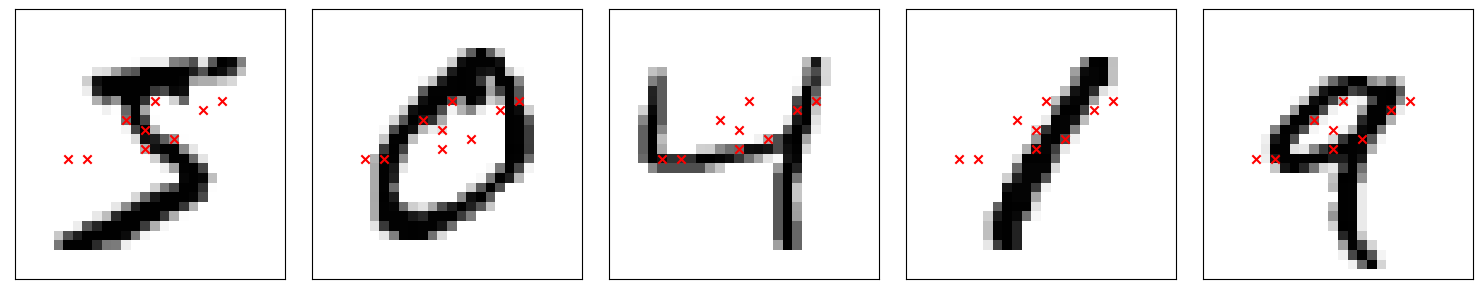

In [18]:
important_indx = np.arange(0, x.shape[1])[feauture_imp > 0.02]
show_data(x, number=5, highlight_pixeles=important_indx, dpi=100, marker='x', c='r')

# Реализовать самостоятельно Random Forest

In [48]:
%timeit

rforest = RandomForestClassifier(100, 1.0)
rforest.fit(x_train, y_train)
serialize(rforest, "rforest")

Accuracy on test:  0.1871


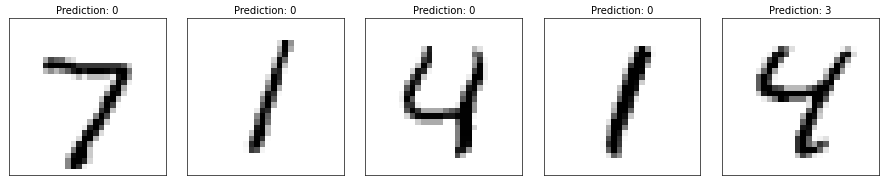

In [54]:
y_pred_rf = rforest.predict(x_test)
show_test_results(y_pred_rf)